# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [3]:
# Load pickled data
import pickle
import os.path

# TODO: Fill this in based on where you saved the training and testing data

training_file = os.path.expanduser('~') + '/test/datasets/traffic-signs/train.p'
testing_file = os.path.expanduser('~') + '/test/datasets/traffic-signs/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [4]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
num_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", num_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

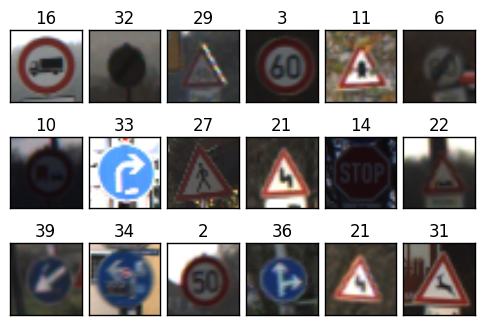

In [8]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import csv
import numpy as np
# Visualizations will be shown in the notebook.
%matplotlib inline

# get sign class annotations
classes = {}
with open('signnames.csv', 'rt') as f:
    for k,v in dict(csv.reader(f)).items():
        if k.isdigit():
            classes[int(k)] = v
    
# index classes
class_indexes = []
for i in range(num_classes):
    class_indexes.append((y_train == i).nonzero()[0])

# show examples of 18 different signs
def show_images(images, classes, shape):
    f, axarr = plt.subplots(*shape)
    for n, ax in enumerate(axarr.flat):
        axarr.flat[n] = ax.imshow(images[n])
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        ax.set_title(str(classes[n]))
    f.subplots_adjust(wspace=0.1)
    f.subplots_adjust(hspace=0.1)

classes_to_show = np.random.randint(num_classes, size=18)
images_to_show = []
for cl in classes_to_show:
    index = np.random.randint(len(class_indexes[cl]))
    index = class_indexes[cl][index]
    images_to_show.append(X_train[index])
show_images(images_to_show, classes_to_show, (3, 6))



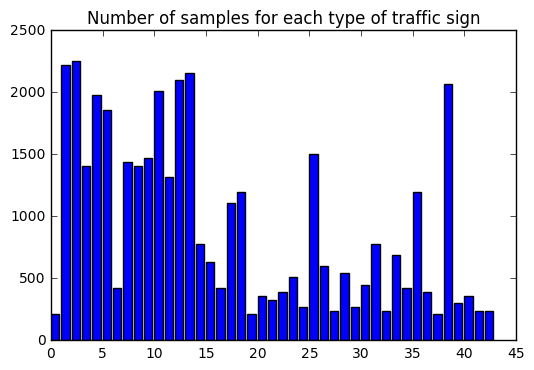

In [4]:
# plot count of each sign
plt.bar(range(num_classes), [len(cl) for cl in class_indexes])
plt.title('Number of samples for each type of traffic sign')
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [5]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
import tensorflow as tf
from sklearn.model_selection import train_test_split

# split the train dataset for train and validation - 90% train, 10% validation
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

# balance the training data set to get equal number of samples (though non-unique) per class
def dataset_balancer(x, y):
    num_classes = len(set(y))
    class_indexes = []
    for i in range(num_classes):
        class_indexes.append((y == i).nonzero()[0])

    x_list = []
    y_list = []
    classes = np.random.randint(num_classes, size=int(len(X_train)*1.1))
    for cl in classes:
        index = np.random.randint(len(class_indexes[cl]))
        index = class_indexes[cl][index]
        x_list.append(x[index:index+1])
        y_list.append(y[index:index+1])
    return np.concatenate(x_list), np.concatenate(y_list)

X_train, y_train = dataset_balancer(X_train, y_train)

In [6]:
#
# normalize and generate distorted data
# Normalization is combined with distortion as distorted data must be then normalized
#
from tqdm import *

CROP_SIZE = 28
NORM_BATCH_SIZE = 128

def normalize_images(input, distort):
    images = tf.cast(input, dtype=tf.float32)
    input_queue = tf.train.slice_input_producer([images], num_epochs=1, shuffle=False)
    image = input_queue[0]

    if distort:
        # Randomly crop a section of the image.
        image = tf.random_crop(image, [CROP_SIZE, CROP_SIZE, 3])
        # Randomly flip the image horizontally.
        image = tf.image.random_flip_left_right(image)
        # randomly adjust brightness and contrast
        image = tf.image.random_brightness(image, max_delta=63)
        image = tf.image.random_contrast(image, lower=0.2, upper=1.8)
    else:
        image = tf.image.resize_image_with_crop_or_pad(image, CROP_SIZE, CROP_SIZE)
    #
    # per image normalization
    # global or per-channel normalization don't work well while testing at new images
    image = tf.image.per_image_standardization(image)
    images = tf.train.batch([image], batch_size=NORM_BATCH_SIZE, allow_smaller_final_batch=True)
    return images


def normalize_inputs(inputs):
    print("Normalizing...")
    norm_list = []
    norm_op = []
    for input, distort in inputs:
        norm_op.append(normalize_images(input, distort))

    with tf.Session() as sess:
        sess.run([tf.global_variables_initializer(), tf.local_variables_initializer()])
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)

        for op, [input, distort] in zip(norm_op, inputs):
            batch_list = []
            for i in tqdm(range(0, len(input), NORM_BATCH_SIZE)):
                norm_batch = sess.run(op)
                batch_list.append(norm_batch)
            norm_list.append(np.concatenate(batch_list))

        coord.request_stop()
        coord.join(threads)

    return norm_list

#
# normalize and generate distored data in a tensorflow session
#
distort = True
X_train_new, X_train_norm, X_validation, X_test = normalize_inputs((
    (X_train, distort), (X_train, not distort), (X_validation, not distort), (X_test, not distort)
))


Normalizing...


100%|██████████| 99/99 [00:20<00:00,  5.28it/s]


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:** I have preprocessed data to have zero mean and unit variance by subtraction of mean and rescaling by unit variance. Usually such preprocessing is performed on per-channel basis (using mean and variance of each input channel individually) or globally (for all input channels). Mean and variance are computed on training set and then used for preprocessing of all data including validation and test datasets. For this project I found that using per-image normalization (mean and variance are computed for each image separately) provides the best result on new test data.

Such preprocessing makes training neural networks (NN) faster and helps to avoid bad local minima and saddle points because NN's weights are initialized assuming zero mean and unit variance inputs. I found that using batch normalization (https://arxiv.org/abs/1502.03167) provides similar effect on networks without preprocessed inputs (assuming inputs are in range 0..255).

In addition, I cropped inputs to 28x28 central patches. Reducing image size was required for generating distorted images by random crops with 28x28 shape. Such crops still contain all information required for classification.



In [8]:
### Generate additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
from sklearn.utils import shuffle

# X_train_new is generated in cell #6, so now we just add it train dataset
X_train = np.append(X_train_norm, X_train_new, axis=0)
y_train = np.append(y_train, y_train, axis=0)

# randomize dataset
X_train, y_train = shuffle(X_train, y_train)
n_train =  len(X_train)
print('New train dataset size: ', n_train)

# train data are already split in cell #5. It had to be done before balancing and new data generation
# to avoid new data generated from validation dataset

# save new data set for later usage
np.savez(
    'traffic_sign_data.npz',
    X_train=X_train, y_train=y_train, X_validation=X_validation, y_validation=y_validation, X_test=X_test, y_test=y_test
)
print('Dataset saved')



Dataset saved


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:** I divided training dataset into training (90%) and validation (10%). Test dataset is left untouched. Validation datasets was used to measure model accuracy to select model architecture and hyperparameters such as learning rate, batch size and etc.

I have generated new data from the training dataset by randomly distorting brightness, contrast, cropping and horizontally flipping images. Without new data or new data with other types of distortion, the trained model had incorrect predictions on new test images. This means that model should be robust to variances of brightness, contrast and sign location within image boundaries.


In [35]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
import math
import tensorflow as tf


def batch_norm(input, is_training):
    return tf.contrib.layers.batch_norm(input, decay=0.9, center=True, scale=True, updates_collections=None, is_training=is_training)


def linear(input, input_size, output_size):
    stdv = 1./math.sqrt(input_size)
    weight = tf.Variable(tf.truncated_normal(shape=(input_size, output_size), mean=0, stddev=stdv))
    bias = tf.Variable(tf.truncated_normal(shape=[output_size], mean=0, stddev=stdv))
    return tf.matmul(input, weight) + bias


def conv2d(input, shape, conv_stride, padding):
    stdv = 1. / math.sqrt(shape[0] * shape[1] * shape[2])
    weight = tf.Variable(tf.truncated_normal(shape=shape, mean=0, stddev=stdv))
    bias = tf.Variable(tf.truncated_normal(shape=[shape[3]], mean=0, stddev=stdv))
    return tf.nn.conv2d(input, weight, strides=[1, conv_stride, conv_stride, 1], padding=padding) + bias


def conv_layer(input, shape, conv_stride, padding, pool, pool_stride, is_training):
    conv = conv2d(input, shape, conv_stride, padding)
    conv = batch_norm(conv, is_training)
    conv = tf.nn.relu(conv)
    if pool > 1:
        conv = tf.nn.max_pool(conv, ksize=[1, pool, pool, 1], strides=[1, pool_stride, pool_stride, 1], padding='VALID')
    return conv


def shortcut(input, input_size, output_size, stride):
    if input_size == output_size:
        return input
    else:
        input = tf.nn.avg_pool(input, ksize=[1, 1, 1, 1], strides=[1, stride, stride, 1], padding='VALID')
        input = tf.pad(input, [[0, 0], [0, 0], [0, 0], [(output_size-input_size)//2, (output_size-input_size)//2]])
        return input


def block(input, input_size, output_size, stride, is_training):
    conv = conv2d(input, shape=(3, 3, input_size, output_size), conv_stride=stride, padding='SAME')
    conv = batch_norm(conv, is_training)
    conv = tf.nn.relu(conv)
    conv = conv2d(conv, shape=(3, 3, output_size, output_size), conv_stride=1, padding='SAME')
    conv = batch_norm(conv, is_training)
    return tf.nn.relu(conv + shortcut(input, input_size, output_size, stride))


def block_layer(input, input_size, output_size, count, stride, is_trainig):
    for i in range(count):
        input = block(input, input_size, output_size, stride if i == 0 else 1, is_trainig)
        input_size = output_size
    return input


def ResNet(input, is_training, dropout):
    conv = conv2d(input, shape=(3, 3, 3, 64), conv_stride=1, padding='SAME')
    conv = batch_norm(conv, is_training)
    conv = tf.nn.relu(conv)
    depth = 20  # 20, 32, 44, 56, 110, 1202
    block_num = (depth - 2) // 6
    conv = block_layer(conv, 64, 64, block_num, 1, is_traing)
    conv = block_layer(conv, 64, 128, block_num, 2, is_traing)
    conv = block_layer(conv, 128, 256, block_num, 2, is_traing)
    conv = tf.nn.avg_pool(conv, ksize=[1, 7, 7, 1], strides=[1, 1, 1, 1], padding='VALID')
    fc0 = tf.contrib.layers.flatten(conv)
    logits = linear(fc0, 256, num_classes)
    return logits


def ConvNet(x, is_training, dropout):
    #x = spatial_transformer(x, ((64, 1), (128, 1), (256, 2), (256, 2)), is_traing, dropout)
    conv1 = conv_layer(x, shape=(3, 3, 3, 64), conv_stride=1, padding='VALID', pool=1, pool_stride=1, is_training=is_training)
    conv2 = conv_layer(conv1, shape=(3, 3, 64, 128), conv_stride=1, padding='VALID', pool=1, pool_stride=1, is_training=is_training)
    #conv2 = spatial_transformer(conv2, ((256, 1), (256, 2)), is_traing, dropout)
    conv3 = conv_layer(conv2, shape=(3, 3, 128, 256), conv_stride=1, padding='VALID', pool=2, pool_stride=2, is_training=is_training)
    conv4 = conv_layer(conv3, shape=(3, 3, 256, 512), conv_stride=1, padding='VALID', pool=2, pool_stride=2, is_training=is_training)
    conv5 = conv_layer(conv4, shape=(3, 3, 512, 1024), conv_stride=1, padding='VALID', pool=2, pool_stride=2, is_training=is_training)
    fc0 = tf.contrib.layers.flatten(conv5)
    fc0 = tf.nn.dropout(fc0, dropout)
    fc1 = linear(fc0, 1024, 256)
    fc1 = batch_norm(fc1, is_training)
    fc1 = tf.nn.relu(fc1)
    logits = linear(fc1, 256, num_classes)
    return logits


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:** Finally I used two models: (1) basic convolutional network with five convolutional layers, (2) residual networks (https://arxiv.org/abs/1512.03385).Both models give 98% accuracy on tets dataset and 85.7% on new test images (14 new images).

In both networks I used batch normalization (https://arxiv.org/abs/1502.03167).

For activations I used rectifier function (ReLU).

Basic convolutional network has following layers:
1) 64 3x3 kernels, stride = 1, batch normalization
2) 128 3x3 kernels, stride = 1, batch normalization
3) 256 3x3 kernels followed by 2x2 max pooling with stride 2, batch normalization
4) 512 3x3 kernels followed by 2x2 max pooling with stride 2, batch normalization
5) 1024 3x3 kernels followed by 2x2 max pooling with stride 2, batch normalization
6) dropout layer
7) 1024 to 256 liner layer
8) batch normalization layer
9) 256 to 43 layer

Residual network has following layers:
1) 64 3x3 kernels
2) batch normalization
3) 3 residual blocks with 64 3x3 kernels
4) 3 residual blocks with 128 3x3 kernels
5) 3 residual blocks with 256 3x3 kernels
6) 7x7 average pooling
7) 256 to 42 linear layer

Each residual block has:
1) convolution layer
2) batch normalization
3) convolution layer
4) batch normalization
5) sum or second convolution layer with original input (so called shortcut)


In [36]:
### Train your model here.
### Feel free to use as many code cells as needed.

rate = 5e-4
EPOCHS = 10
BATCH_SIZE = 128
CROP_SIZE = 28

x = tf.placeholder(tf.float32, (None, CROP_SIZE, CROP_SIZE, 3))
y = tf.placeholder(tf.int32, (None))
one_image = tf.placeholder(tf.float32, (32, 32, 3))
is_traing = tf.placeholder(tf.bool)
dropout = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, num_classes)

logits = ConvNet(x, is_traing, dropout)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer(learning_rate=rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()


In [37]:
#
# Evaluation function
#
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    class_correct = list(0. for i in range(num_classes))
    class_total = list(0. for i in range(num_classes))
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy, correct = sess.run([accuracy_operation, correct_prediction], feed_dict={
            x: batch_x, y: batch_y, is_traing: False, dropout: 1
        })
        for i in range(len(batch_y)):
            cl = batch_y[i]
            class_correct[cl] += correct[i]
            class_total[cl] += 1
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples, class_correct, class_total


In [38]:
import time
#
# load data
#
data = np.load('traffic_sign_data.npz')
X_train, y_train, X_validation, y_validation, X_test, y_test = \
    data['X_train'], data['y_train'], data['X_validation'], data['y_validation'], data['X_test'], data['y_test']
#
# Training session
#
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    num_examples = len(X_train)

    print("Training...")
    print()

    for i in range(EPOCHS):
        training_loss = 0
        epoch_time = time.time()
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            _, loss = sess.run([training_operation, loss_operation], feed_dict={
                x: batch_x, y: batch_y, is_traing: True, dropout: 0.5
            })
            training_loss += loss

        training_loss /= num_examples
        validation_accuracy, _, _ = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i + 1))
        print("Training loss = {:.10f}, Validation Accuracy = {:.6f}, time = {:.3f}".format(
            training_loss, validation_accuracy, time.time() - epoch_time
        ))
        print()

    saver.save(sess, './model')
    print("Model saved")


Training...

EPOCH 1 ...
Training loss = 0.0031435965, Validation Accuracy = 0.996174, time = 37.177

EPOCH 2 ...
Training loss = 0.0003376818, Validation Accuracy = 0.997705, time = 37.038

EPOCH 3 ...
Training loss = 0.0001973659, Validation Accuracy = 0.997705, time = 37.478

EPOCH 4 ...
Training loss = 0.0001395996, Validation Accuracy = 0.995919, time = 37.689

EPOCH 5 ...
Training loss = 0.0001215714, Validation Accuracy = 0.994644, time = 37.748

EPOCH 6 ...
Training loss = 0.0001065066, Validation Accuracy = 0.996940, time = 37.881

EPOCH 7 ...
Training loss = 0.0000870517, Validation Accuracy = 0.997960, time = 37.911

EPOCH 8 ...
Training loss = 0.0000660132, Validation Accuracy = 0.997195, time = 37.879

EPOCH 9 ...
Training loss = 0.0000823864, Validation Accuracy = 0.995154, time = 39.127

EPOCH 10 ...
Training loss = 0.0000546136, Validation Accuracy = 0.997705, time = 37.949

Model saved


Test Accuracy = 0.973


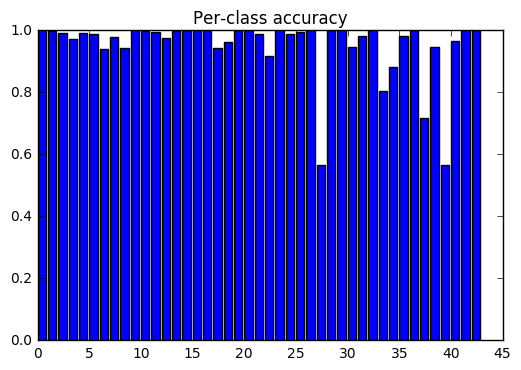

#0                               Speed limit (20km/h):	100%
#1                               Speed limit (30km/h):	100%
#2                               Speed limit (50km/h):	99%
#3                               Speed limit (60km/h):	97%
#4                               Speed limit (70km/h):	99%
#5                               Speed limit (80km/h):	99%
#6                        End of speed limit (80km/h):	94%
#7                              Speed limit (100km/h):	98%
#8                              Speed limit (120km/h):	94%
#9                                         No passing:	100%
#10       No passing for vehicles over 3.5 metric tons:	100%
#11              Right-of-way at the next intersection:	100%
#12                                      Priority road:	98%
#13                                              Yield:	100%
#14                                               Stop:	100%
#15                                        No vehicles:	100%
#16           Vehicles over 3.5 metric ton

In [39]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy, class_correct, class_total = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    class_accuracy = [class_correct[i] / class_total[i] for i in range(num_classes)]
    plt.bar(range(num_classes), class_accuracy)
    plt.title('Per-class accuracy')
    plt.show()
    for i in range(num_classes):
        print('#{} {:>50}:\t{:.0f}%'.format(i, classes[i], class_accuracy[i]*100))



### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:** For training I used Adam optimizer (https://arxiv.org/abs/1412.6980) which quite robust to the choice of learning rate. 

The training is done in batches of size 128. Smaller batch size caused oscillated loss function, bigger batch size decreased final accuracy. 

The number of epochs is 20, after which the model stops improving.

The training rate is 0.0005, selected among (0.01, 0.001, 0.0001, 0.00001) as providing best result.


### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:** I have analyzed various architectures and stopped on two: (1) basic convolutional network with five convolutional layers, (2) residual networks (https://arxiv.org/abs/1512.03385). Both were able to achieve more than 99% accuracy on test data while trained on data without distortion. However, models showing over 99% on test data and less than 10% accuracy on new test data. Hence using distorted data described in answer to Question 1 is necessary. With new distorted data the models give 97-98% accuracy on tets dataset and 85.7% on new test images (14 new images).

Deeper acrtictures provided better results, so I used 3x3 kernels with more convolutional layers instead of shallower networks with 5x5, 7x7 or bigger kernels. Another important factor is number of kernels (filters). It is important to use 32 or more kernels starting from the very first convolutional layer. Using less kernels decreased performance.

In both networks I used batch normalization (https://arxiv.org/abs/1502.03167) which is very important to achieve quick convergence. Without batch normalization training takes much longer and results are worse.

The shortcut may pass features from several layers below and lets gradient bypass the layers. The later fixes gradient vanishing and makes dozens and hundred layers working well.

I also tried adding spatial transformers (https://arxiv.org/pdf/1506.02025.pdf) as they were reported providing good results on German traffic sign dataset (http://torch.ch/blog/2015/09/07/spatial_transformers.html). That was not difficult as there is a tensorflow implementation https://github.com/tensorflow/models/tree/master/transformer. I  added spatial transformers with convolutional localization network at first and third layers of basic convolutional model. Indeed, with spatial transformer improves accuracy on test dataset by 0.5%. Once I got 95.5% accuracy. Howevever, this improvement does not affect new test images which is more important criterion. Given that spatial transformers triple training time I decided not to use them in the final model.


---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

Test images:


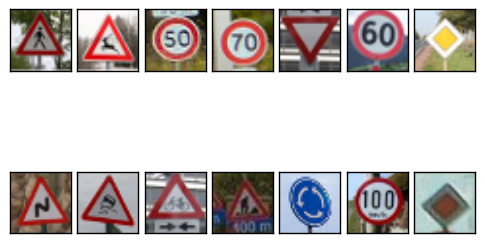

In [40]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
#
# test images found at https://www.google.com/search?q=priority+road+traffic+sign&num=100&source=lnms&tbm=isch
# cropped and rescaled to 32x32 by GIMP (https://www.gimp.org/)
# exported to BMP with "R5 G6 B5" option
#
import matplotlib.image as mpimg
test_images = []
test_dir = os.path.expanduser('~') +  "/test/datasets/traffic-signs/"
for file_name in os.listdir(test_dir):
    base, ext = os.path.splitext(file_name)
    if ext == '.bmp':
        #print(file_name)
        image = mpimg.imread(test_dir + file_name)
        test_images.append(image)

print('Test images:')
show_images(test_images, ['']*len(test_images), (2, len(test_images)//2))
        

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:** Initially I got less than 10% accuracy on the new test images. Once I added new training data with random flipping, cropping, distorted brightness and contrast, accuracy on new test images improved to 85.7% (12/14). Hence network is quite sensitive to brightness contrast and location of sign within image boundaries. I'm sure there are other factors and additional distortions such as, e.g. tf.image.random_saturation(), tf.image.random_hue(), may further improve accuracy on new test images.

Also I found it is important to use per-image normalization which helps to mitigate difference color schemas between training and new test images.


Selected test images:


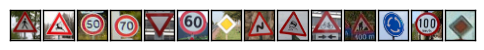

In [41]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
CROP_SIZE = 28
test_image = tf.placeholder(tf.float32, (32, 32, 3))
test_image_op = tf.image.resize_image_with_crop_or_pad(test_image, CROP_SIZE, CROP_SIZE)
test_image_op = tf.image.per_image_standardization(test_image_op)
test_image_op = tf.reshape(test_image_op, [1, CROP_SIZE, CROP_SIZE, 3])

# select 5 images
NUM_IMAGES = 14
test_images = test_images[:NUM_IMAGES]
print('Selected test images:')
show_images(test_images, ['']*NUM_IMAGES, (1, NUM_IMAGES))

#
# proceed with predictions
#
softmax_operation = tf.nn.softmax(logits)
predictions = []

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    for image in test_images:
        # get class
        plt.imshow(image)
        norm_image = sess.run(test_image_op, feed_dict={test_image: image})
        prob = sess.run(softmax_operation, feed_dict={x: norm_image, is_traing: False, dropout: 1})[0]
        predictions.append(prob)


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:** The accuracy on testing dataset is 97-98%, while on new test images is 85.7%. The mis-classifications appear in the following cases:
1) speed limit 60 is classified as speed limit 80, 60 is in the top-5
2) speed limit 100 is classified as speed limit 80, 100 is in the top-5

I picked all 14 new images, not just 5 candidates. 14 is still small enough and analysis is more complete.

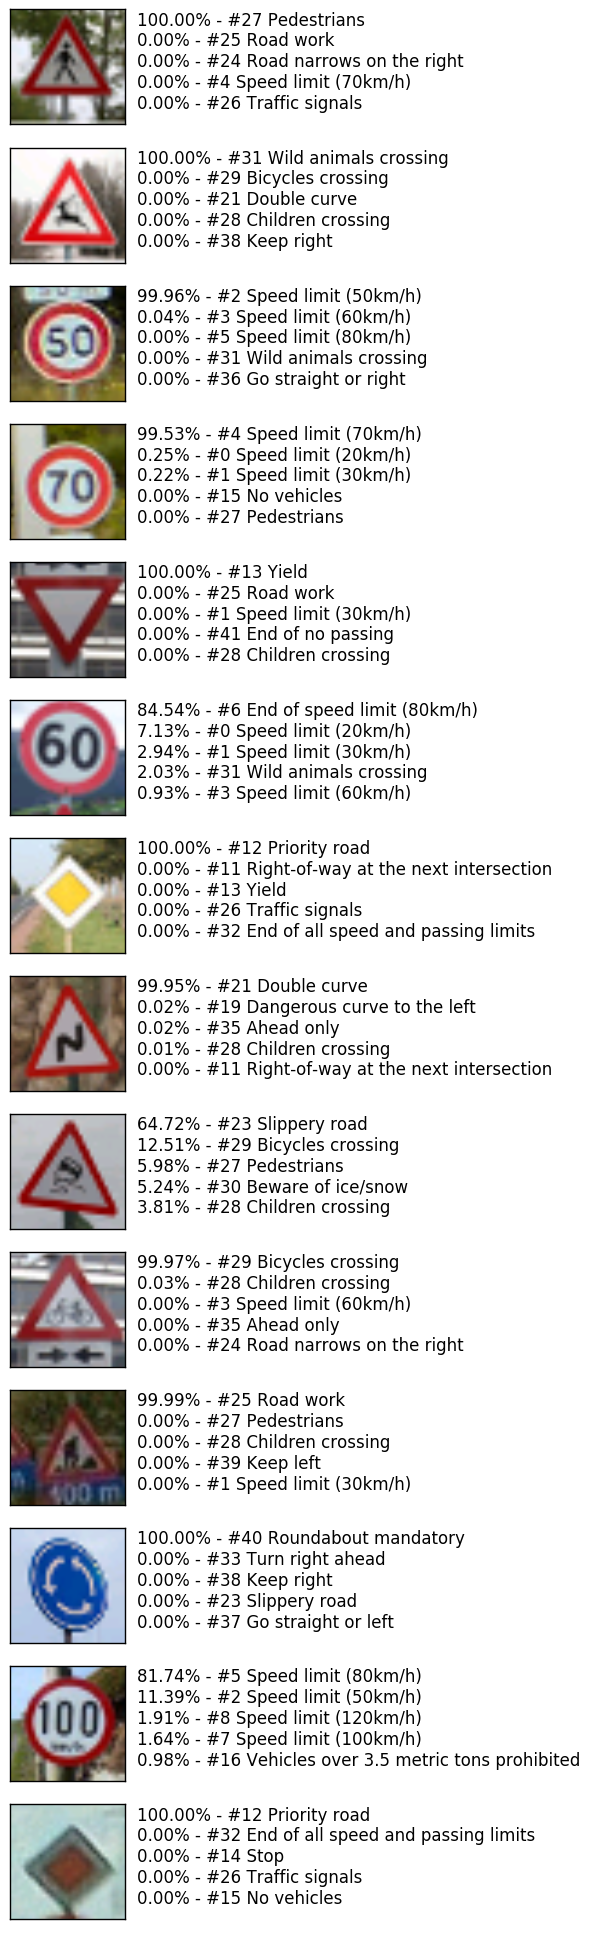

In [42]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

class_index = [prob.argsort()[::-1] for prob in predictions]
title_list = []
for image, prob, index in zip(test_images, predictions, class_index):
    #  top-5
    title = ''
    for i in index[:5]:
        title += '{:.2f}% - #{} {}\n'.format(prob[i]*100, i, classes[i])
    title_list.append(title)
    
f, axarr = plt.subplots(NUM_IMAGES, 1)
for n, ax in enumerate(axarr.flat):
    axarr.flat[n] = ax.imshow(test_images[n])
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.set_title(title_list[n], loc='left', y=-0.1, x=1.1)
    
f.subplots_adjust(top=NUM_IMAGES*0.35)


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:** The model is certain above 99% on 11 out of 14 images. All certain predictions are correct. One image with lower certanty (64%) has correct classification. Other two are classified incorrectly. When model prediction is wrong, right class is still in top-5 predictions though with very low certainty at about 1%. One image 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.